In [39]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torchvision.utils import save_image

In [40]:
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
from pytorch3d.renderer import TexturesVertex
from pytorch3d.ops import sample_points_from_meshes

import trimesh
from trimesh.voxel import creation
from trimesh.viewer import in_notebook

from scene import Scene

In [41]:
device = torch.device('cuda:0')
obj_list = sorted(glob.glob('../data/chair/*/*.obj'))

In [42]:
db = sorted(glob.glob(os.path.join("../data/chair", '*/')))

print(os.path.join(db[2], 'view.png'))
print(db[2].split('/'))

../data/chair/100b18376b885f206ae9ad7e32c4139d/view.png
['..', 'data', 'chair', '100b18376b885f206ae9ad7e32c4139d', '']


In [43]:
def load_mesh(obj, device):
    verts, faces, _ = load_obj(obj, load_textures=False)
    faces_idx = faces.verts_idx

    verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
    textures = TexturesVertex(verts_features=verts_rgb.to(device))

    mesh = Meshes(
        verts=[verts.to(device)],
        faces=[faces_idx.to(device)],
        textures=textures
    )

    return mesh

In [44]:
scene = Scene(device=device)
#scene.set_cam(1.7, 50, 90)
scene.set_light(location=[[0.0, 0.0, 0.0]])
scene.set_rasterizer(image_size=256)
#scene.set_renderer()

In [45]:
import shutil
import os

pbar = tqdm(obj_list)

for obj in pbar:
    id = obj.split('/')[3]
    path = obj.replace('model.obj', '')
    pbar.set_description(f"Processing: {id}")

    if not os.path.exists(os.path.join(path, "voxel.npy")):
        print(path)
    
#     if os.path.exists(os.path.join(path, "model.mtl")):
#         os.remove(os.path.join(path, "model.mtl"))

#     if os.path.exists(os.path.join(path, "models/")):
#         print(os.path.join(path, "models/"))
#         os.rmdir(os.path.join(path, "models/"))

#     if os.path.exists(os.path.join(path, "images/")):
#         print(os.path.join(path, "images/"))
#         shutil.rmtree(os.path.join(path, "images/"))

  0%|          | 0/6778 [00:00<?, ?it/s]

In [46]:
len(obj_list)

6778

  0%|          | 0/1 [00:00<?, ?it/s]

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/hbr/anaconda3/envs/py3d/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/hbr/anaconda3/envs/py3d/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
specified material (material_0)  not loaded!
specified material (material)  not loaded!
concatenating texture: may result in visual artifacts
Mesh is non-watertight for contained point query!
/tmp/ipykernel_2232/2302619767.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/re

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

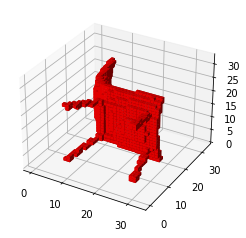

In [51]:
# pbar = tqdm(obj_list[4480:])
pbar = tqdm(obj_list[:1])

for obj in pbar:
    id = obj.split('/')[3]
    path = obj.replace('model.obj', '')
    # print(path)
    pbar.set_description(f"Processing: {id}")

    mesh = load_mesh(obj, device)
    elev = np.random.randint(0, 45, 1)
    azim = np.random.randint(30, 150, 1)
    scene.set_cam(1.0, elev, azim)
    scene.set_renderer()
    image = scene.renderer(mesh)
    image = image[0, ..., :3].permute(2, 0, 1)
    save_image(image, path+'view.png')

    # point_cloud = sample_points_from_meshes(mesh,num_samples=2048)
    # point_cloud = point_cloud.squeeze(0)
    # np.save(path + 'point_cloud',point_cloud.cpu().numpy())
    # mesh = tri_load_obj(path, skip_materials=False)
    mesh = trimesh.load(obj, file_type='obj', resolver=None, force='mesh', skip_materials=True)
    # print(type(mesh))
    voxel = creation.local_voxelize(mesh, mesh.centroid, mesh.extents.max() / 32, radius=16, fill=True)
    # print(voxel.shape)
    np_voxel = np.array(voxel.encoding.data, dtype=np.bool)
    # np_voxel = np.array(voxel.matrix)  
    np.save(path + 'voxel',np_voxel)
    print(np_voxel)
    is_nt = in_notebook()
    print(is_nt)
    voxel.show()
    ax = plt.figure().add_subplot(projection='3d')
    # ax.voxels(np_voxel, facecolors='red', edgecolor='k')
    ax.voxels(np_voxel, facecolors='red')

    
    